# Loading and Looking at theData

In [1377]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, homogeneity_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction import text
import numpy as np
%matplotlib inline

In [1378]:
df = pd.read_csv('Tweets.csv')

In [1379]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [1380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [1381]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [1382]:
df['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [1383]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

# Clean the Data

In [1384]:
# Drop rows with too many nans

df = df.drop(['airline_sentiment_gold', 'negativereason_gold'], axis=1)

In [1385]:
print 'The baseline is', 9178.0 / (9178 + 3099 + 2363)

The baseline is 0.626912568306


# Log Reg?

In [1386]:
le = LabelEncoder()
y = le.fit_transform(df['airline_sentiment'])

X_train, X_test, y_train, y_test = train_test_split(df['text'], y, stratify=y, test_size=0.33, random_state=42)



In [1387]:
mine = ['virginamerica', 'americanair','united', 'southwest', 'southwestair', 'delta', 'usairways','american']

tfv = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(mine),
                      token_pattern='[a-zA-Z]{3,50}',ngram_range=(1,3), min_df=2, max_df=0.8, sublinear_tf=True)
tfv.fit(df['text'])
XX_train = tfv.transform(X_train)
XX_test = tfv.transform(X_test)
XX_all = tfv.transform(df['text'])

In [1388]:
lr = LogisticRegression(multi_class='multinomial', solver='sag', random_state=42)
gs = GridSearchCV(lr, param_grid={'C':[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]}, cv=5)
gs.fit(XX_train, y_train)
gs.best_params_

{'C': 10.0}

In [1389]:
lr = LogisticRegression(C=10.0, multi_class='multinomial', solver='sag', random_state=42)
lr.fit(XX_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [1390]:
coefs = pd.DataFrame(lr.coef_)
coefs.columns = tfv.vocabulary_
coefs
dicty = {}
for i in coefs:
    dicty[i] = [sum(abs(coefs[i]))]
dicty
from operator import itemgetter
log_reg_imp = sorted(dicty.items(), key=itemgetter(1), reverse=True)

In [1391]:
coefs

,shows delayed,issues given bonus,airline world,caned,screaming,wednesday,hanging,donate http,maatkare hope,kids,...,weather humor,fantastic customer service,getting,disorganized,delay voucher,paid extra,really need better,sick,gas,hours time worth
0,0.175077,0.175077,-1.242715,-0.38485,0.093332,0.186102,0.119168,0.0,0.871001,-1.322204,...,0.427399,0.427399,1.143045,0.397457,-1.064725,-0.075797,-0.075797,0.548283,-0.507413,1.371559
1,-0.118417,-0.118417,1.532162,0.51623,-0.083093,-0.119380,-0.076588,0.0,-0.303690,-0.706661,...,-0.310717,-0.310717,-0.558017,-0.212276,0.487625,0.265625,0.265625,-0.421632,0.631696,-0.868670
2,-0.056661,-0.056661,-0.289447,-0.13138,-0.010239,-0.066722,-0.042580,0.0,-0.567311,2.028865,...,-0.116682,-0.116682,-0.585027,-0.185181,0.577100,-0.189828,-0.189828,-0.126652,-0.124283,-0.502890


In [1392]:
t_coefs = coefs.T
t_coefs.columns = ['negative', 'neutral', 'positive']
neg = []
for i in t_coefs['negative']:
    if i > 0:
        neg.append(-1*i)
    else:
        neg.append(0)
pos = []
for i in t_coefs['positive']:
    if i > 0:
        pos.append(i)
    else:
        pos.append(0)
pos
zipped = zip(neg, pos)
together = []
for i in zipped:
    together.append(sum(i))
together = pd.DataFrame(together, index=coefs.columns)
tog = together.T
tog

,shows delayed,issues given bonus,airline world,caned,screaming,wednesday,hanging,donate http,maatkare hope,kids,...,weather humor,fantastic customer service,getting,disorganized,delay voucher,paid extra,really need better,sick,gas,hours time worth
0,-0.175077,-0.175077,0.0,0.0,-0.093332,-0.186102,-0.119168,0.0,-0.871001,2.028865,...,-0.427399,-0.427399,-1.143045,-0.397457,0.5771,0.0,0.0,-0.548283,0.0,-1.371559


In [1393]:
y_pred = lr.predict(XX_test)
lr.score(XX_test, y_test)

0.76055463576158944

In [1394]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.81      0.90      0.85      3029
          1       0.57      0.50      0.53      1023
          2       0.76      0.57      0.65       780

avg / total       0.75      0.76      0.75      4832



In [1395]:
con = confusion_matrix(y_test, y_pred)
con

array([[2713,  247,   69],
       [ 438,  516,   69],
       [ 185,  149,  446]])

In [1396]:
# 50 most important words
most_imp = sorted([i[0] for i in log_reg_imp])[:50]
len(most_imp)

50

In [1397]:
tfv = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(mine), token_pattern='[a-zA-Z]{3,50}',ngram_range=(1,3),
                      min_df=2, max_df=0.1, sublinear_tf=True, max_features=100)
X_sb = tfv.fit_transform(df['text'])


sb = SelectKBest(f_classif, k=67)
sb.fit(X_sb, y)

SelectKBest(k=67, score_func=<function f_classif at 0x114242c08>)

In [1398]:
mask = sb.get_support()
imp = pd.DataFrame(np.asarray(tfv.get_feature_names())[sb.get_support()])

# Vectorizing the Tweets

In [1399]:
tfv = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(mine), token_pattern='[a-zA-Z]{3,50}',ngram_range=(1,2), min_df=2, max_df=0.8,vocabulary=imp[0])
X = tfv.fit_transform(df['text'])
X_dense = pd.DataFrame(X.todense())
voc = tfv.vocabulary_
X_dense.columns = voc

In [1400]:
X_dense.head()

,love,help,flight cancelled,number,thanks,tomorrow,staff,late,hold,late flight,...,wait,great,don,luggage,days,experience,baggage,airline,time,flightled
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.740851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1401]:
from operator import itemgetter
dicty = {}
for i in X_dense:
    dicty[i] = sum(X_dense[i])
print '10 most common words'
sorted(dicty.items(), key=itemgetter(1), reverse=True)[:10]

10 most common words


[(u'need', 858.16920848311565),
 (u'don', 735.13909594223219),
 (u'bad', 506.35475149124841),
 (u'response', 476.53967009256814),
 (u'luggage', 472.55397784213352),
 (u'great', 460.97518680201671),
 (u'late', 447.70772883582151),
 (u'trying', 397.79753134726946),
 (u'hours', 382.23414232667602),
 (u'crew', 369.28774056625656)]

# SVD and Hierarchical Clustering

In [1402]:
scaler = StandardScaler(with_mean=False)


trunc = TruncatedSVD(n_components=43)

truncy = pd.DataFrame(trunc.fit_transform(X))

In [1403]:
import numpy as np
pd.DataFrame(trunc.explained_variance_ratio_)[:10]

,0
0,0.055607
1,0.044209
2,0.034438
3,0.035378
4,0.034678
5,0.030210
6,0.030053
7,0.025483
8,0.024129
9,0.022721


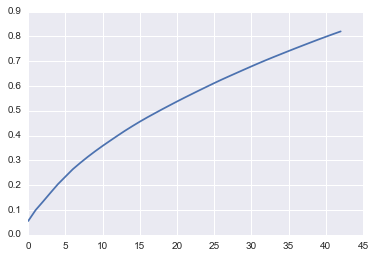

In [1404]:
plt.plot(np.cumsum(trunc.explained_variance_ratio_))

In [1405]:
km = AgglomerativeClustering(n_clusters=3)
km.fit(truncy)
labels = pd.DataFrame(km.labels_)

km2 = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=30)
km2.fit(truncy, y)
labels2 = pd.DataFrame(km2.labels_)


In [1406]:
y_pred = np.choose(labels, [0,1,2])
le = LabelEncoder()
thing['airline_sentiment'] = le.fit_transform(thing['airline_sentiment'])
print classification_report(thing['airline_sentiment'], y_pred)
print confusion_matrix(thing['airline_sentiment'], y_pred)
print 'Homogeneity Score:', homogeneity_score(thing['airline_sentiment'], y_pred[0])
print 'Rand:', adjusted_rand_score(thing['airline_sentiment'], y_pred[0])

             precision    recall  f1-score   support

          0       0.66      0.97      0.79      9178
          1       0.59      0.11      0.19      3099
          2       0.65      0.13      0.22      2363

avg / total       0.64      0.66      0.57     14640

[[8931  162   85]
 [2665  350   84]
 [1963   85  315]]
Homogeneity Score: 0.0413869173977
Rand: 0.0963237565701


In [1407]:
y_pred2 = np.choose(labels2, [0,1,2])
le = LabelEncoder()
thing['airline_sentiment'] = le.fit_transform(thing['airline_sentiment'])
print classification_report(thing['airline_sentiment'], y_pred2)
print confusion_matrix(thing['airline_sentiment'], y_pred2)
print 'Homogeneity Score:', homogeneity_score(thing['airline_sentiment'], y_pred2[0])
print 'Rand:', adjusted_rand_score(thing['airline_sentiment'], y_pred2[0])

             precision    recall  f1-score   support

          0       0.27      0.03      0.05      9178
          1       0.48      0.15      0.23      3099
          2       0.13      0.68      0.21      2363

avg / total       0.29      0.16      0.12     14640

[[ 268  337 8573]
 [ 155  459 2485]
 [ 582  165 1616]]
Homogeneity Score: 0.054717004908
Rand: 0.137762129876


In [1408]:
dingus = pd.concat([df,X_dense], axis=1)

In [1409]:
dingus.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,...,wait,great,don,luggage,days,experience,baggage,airline,time,flightled
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1410]:
dingus.to_csv('word_data.csv')

# Trying with just neg and pos

In [1411]:
df_pos = df[df['airline_sentiment']=='positive']
df_neg = df[df['airline_sentiment']=='negative']
df_neg = df_neg[df_neg.index % 3 == 0]
print len(df_neg)
print len(df_pos)
posneg_df = pd.concat([df_pos, df_neg], axis=0)
len(posneg_df)

3069
2363


5432

In [1746]:

mine = ['virginamerica', 'americanair','united', 'southwest', 'southwestair', 'delta', 'usairways','american']

tfv = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(mine), token_pattern='[a-zA-Z]{3,50}',
                      ngram_range=(1,2), min_df=5, max_df=0.6, max_features=25)
X_neg = tfv.fit_transform(posneg_df[posneg_df['airline_sentiment'] == 'negative']['text'])
X_dense_neg = pd.DataFrame(X_neg.todense())
voc_neg = tfv.vocabulary_
X_dense_neg.columns = voc_neg


In [1747]:
tfv = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(mine), token_pattern='[a-zA-Z]{3,50}',
                      ngram_range=(1,2), min_df=5, max_df=0.6, max_features=15)
X_pos = tfv.fit_transform(posneg_df[posneg_df['airline_sentiment'] == 'positive']['text'])
X_dense_pos = pd.DataFrame(X_pos.todense())
voc_pos = tfv.vocabulary_
X_dense_pos.columns = voc_pos


In [1748]:
score_listy = []
voc_listy = []
for i in voc_pos:
    voc_listy.append(i)
    score_listy.append(10)
for i in voc_neg:
    voc_listy.append(i)
    score_listy.append(-10)

scores = pd.DataFrame(voc_listy)
scores['scores'] = score_listy
scores.columns = ['voc', 'score']
print len(scores)
scores.drop_duplicates('voc', inplace=True)
print len(scores)
scores

40
34


,voc,score
0,best,10
1,love,10
2,awesome,10
3,service,10
4,great,10
5,customer,10
6,thanks,10
7,guys,10
8,http,10
9,just,10


In [1749]:
scores['score'].value_counts()

-10    19
 10    15
Name: score, dtype: int64

In [1750]:
weights = {}
for idx, i in enumerate(posneg_df['text']):
    for j in scores[scores['score'] == 10]['voc']:
        if str(j) in str(i):
            if idx not in weights:
                weights[idx] = 1
            else:
                weights[idx] += 1
    for k in scores[scores['score'] == -10]['voc']:
        if str(k) in str(i):
            if idx not in weights:
                weights[idx] = -1
            else:
                weights[idx] -= 1
    if idx not in weights:
        weights[idx] = 0


In [1751]:
weights = pd.DataFrame(weights.values())
weights[0].value_counts()

 0    1976
 1    1312
-1     896
 2     585
-2     305
 3     171
-3     122
-4      28
 4      25
 5       8
-5       3
 6       1
Name: 0, dtype: int64

In [1977]:
tfv = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(mine), token_pattern='[a-zA-Z]{3,50}',ngram_range=(1,3),
                      min_df=2, max_df=0.1, sublinear_tf=True, vocabulary=scores['voc'])
X_sb = tfv.fit_transform(posneg_df['text'])
le = LabelEncoder()
y = le.fit_transform(posneg_df['airline_sentiment'])

sb = SelectKBest(f_classif, k=5)
sb.fit(X_sb, y)


SelectKBest(k=5, score_func=<function f_classif at 0x114242c08>)

In [1978]:
mask = sb.get_support()

imp = pd.DataFrame(np.asarray(tfv.get_feature_names())[mask])
imp.head()

,0
0,great
1,thanks
2,jetblue
3,thank
4,hours


In [1979]:
tfv = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(mine), token_pattern='[a-zA-Z]{3,50}',
                      ngram_range=(1,2), vocabulary=imp[0])
X = tfv.fit_transform(posneg_df['text'])
X_dense = pd.DataFrame(X.todense())
voc = tfv.vocabulary_
X_dense.columns = voc


In [1980]:
from operator import itemgetter
dicty = {}
for i in X_dense:
    dicty[i] = sum(X_dense[i])
print '10 most common words'
sorted(dicty.items(), key=itemgetter(1), reverse=True)[:10]

10 most common words


[(u'thanks', 765.69105324130317),
 (u'great', 630.09876464741797),
 (u'jetblue', 437.94933401698052),
 (u'thank', 227.63099147524889),
 (u'hours', 214.82141610089948)]

In [1981]:
X = pd.concat([X_dense, weights], axis=1)

In [1982]:
X.head()

,hours,great,thanks,jetblue,thank,0
0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0


In [1983]:

trunc = PCA(n_components=5)

truncy = pd.DataFrame(trunc.fit_transform(X))

In [1984]:
import numpy as np
pd.DataFrame(trunc.explained_variance_ratio_)[:10]

,0
0,0.840834
1,0.053769
2,0.044028
3,0.029882
4,0.016639


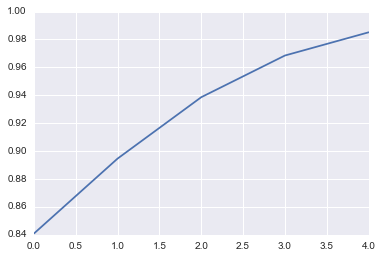

In [1985]:
plt.plot(np.cumsum(trunc.explained_variance_ratio_))

In [1986]:
km = AgglomerativeClustering(n_clusters=2)
km.fit(truncy)
labels = pd.DataFrame(km.labels_)

km2 = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km2.fit(truncy)
labels2 = pd.DataFrame(km2.labels_)


In [1987]:
y_pred = np.choose(labels, [0,1])

print classification_report(y, y_pred)
print confusion_matrix(y, y_pred)
print 'Homogeneity Score:', homogeneity_score(y, y_pred[0])
print 'Rand:', adjusted_rand_score(y, y_pred[0])

             precision    recall  f1-score   support

          0       0.72      0.74      0.73      3069
          1       0.65      0.63      0.64      2363

avg / total       0.69      0.69      0.69      5432

[[2264  805]
 [ 879 1484]]
Homogeneity Score: 0.100055289337
Rand: 0.143869011515


In [1989]:
y_pred2 = np.choose(labels2, [0,1])
print classification_report(y, y_pred2)
print confusion_matrix(y, y_pred2)
print 'Homogeneity Score:', homogeneity_score(y, y_pred2[0])
print 'Rand:', adjusted_rand_score(y, y_pred2[0])

             precision    recall  f1-score   support

          0       0.68      0.74      0.71      3069
          1       0.63      0.56      0.59      2363

avg / total       0.66      0.66      0.66      5432

[[2281  788]
 [1049 1314]]
Homogeneity Score: 0.06827220895
Rand: 0.103813740497


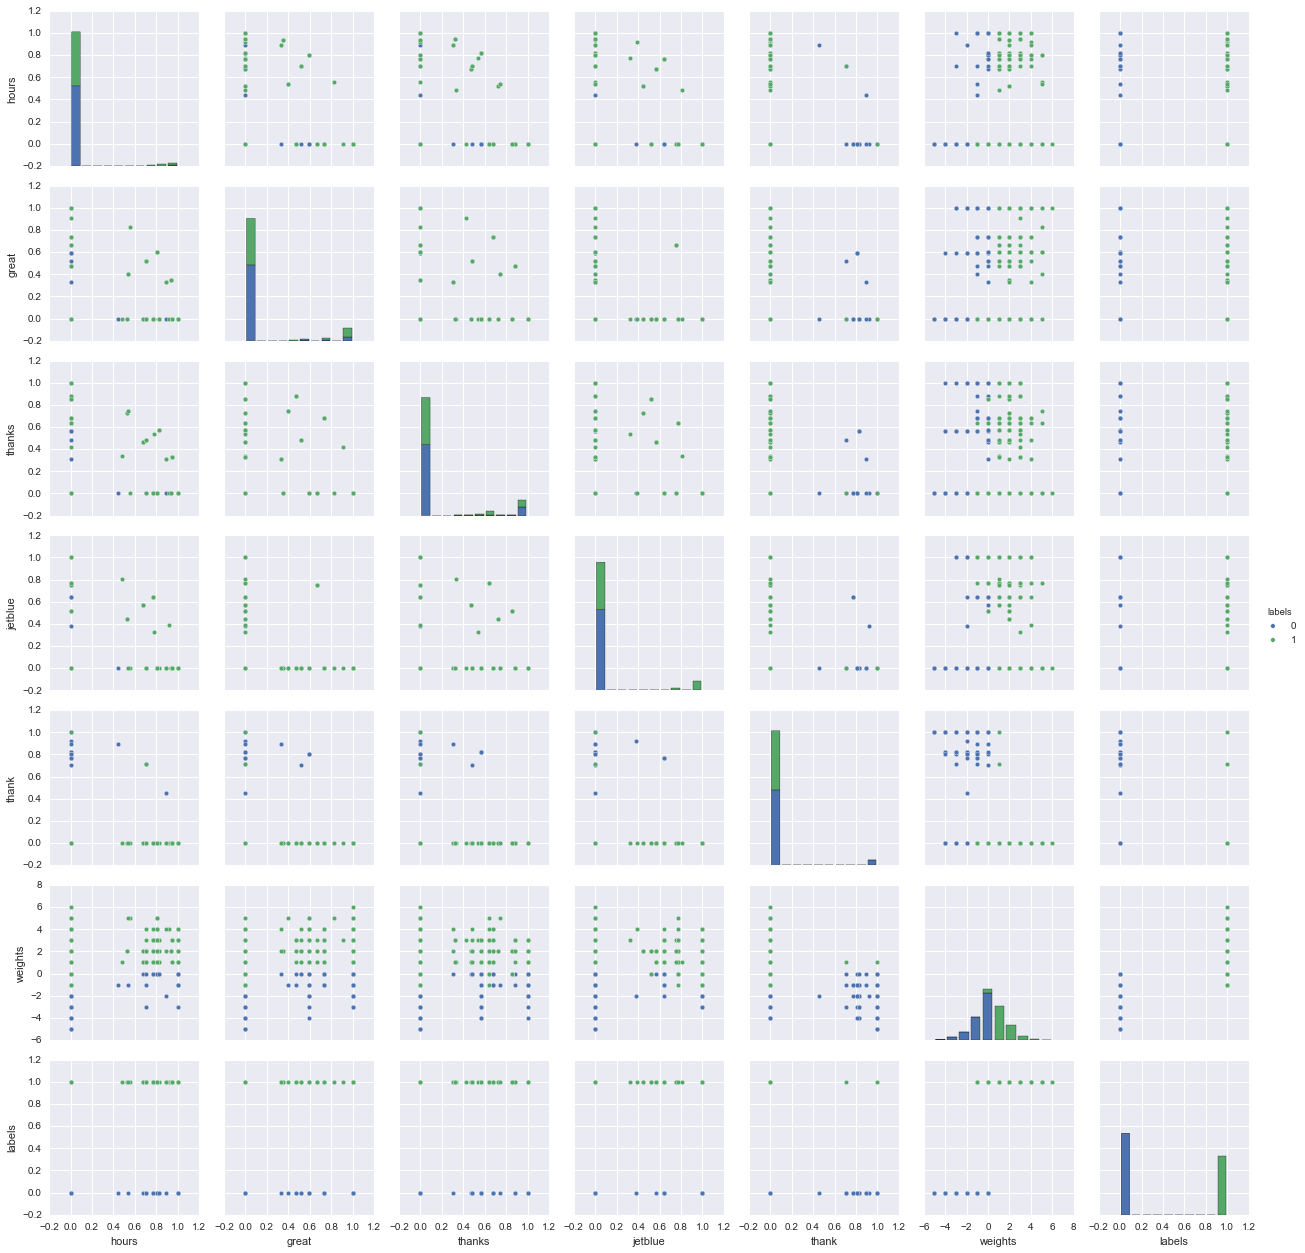

In [1993]:
for_plot = pd.concat([X, pd.DataFrame(y_pred)], axis=1)
for_plot.columns = ['hours', 'great', 'thanks', 'jetblue', 'thank', 'weights', 'labels']
sns.pairplot(for_plot, hue='labels')